In [1]:
import torch
assert '.'.join(torch.__version__.split('.')[:2]) == '1.5'
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T
import os
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import save_image
from IPython.display import clear_output

from scipy import linalg
from skimage.util import dtype

import torch.nn.functional as F  # useful stateless functions

from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.color import rgb2ycbcr, ycbcr2rgb
from skimage.color import rgb2xyz, xyz2rgb

import cv2

In [2]:
def degradation(img, scale):
    h, w, _ = img.shape
    new_height = h // scale
    new_width = w // scale
        
    # сжимаем картинку, чтобы ухудшить качество
    img = cv2.resize(img, (new_width, new_height), interpolation = cv2.INTER_CUBIC)
    return img

def create_bicubic(img, scale):
    h, w, _ = img.shape
    img = degradation(img, scale)
    return cv2.resize(img, (w, h), interpolation = cv2.INTER_CUBIC)
    
def shave(image):
    # border1 = image.shape[0] - image.shape[0] % 4
    # border2 = image.shape[1] - image.shape[1] % 4
    border1 = border2 = 76
    img = image[:border1, :border2, :]
    return img

imgs_hd = []
imgs_x4 = []
imgs_bicubic = []
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
folder_path = "/content/gdrive/My Drive/Train"
filenames = np.array(os.listdir(folder_path))
for filename in filenames:
    img_hd = plt.imread(os.path.join(folder_path, filename))
    img_hd = shave(img_hd)
    img_x4 = degradation(img_hd, 4)
    img_bicubic = create_bicubic(img_hd, 4)
    img_hd = rgb2ycbcr(img_hd / 255.0)
    img_x4 = rgb2ycbcr(img_x4 / 255.0)
    img_bicubic = rgb2ycbcr(img_bicubic / 255.0)
    img_hd = np.transpose(img_hd, [2, 0, 1])
    img_x4 = np.transpose(img_x4, [2, 0, 1])
    img_bicubic = np.transpose(img_bicubic, [2, 0, 1])
    imgs_hd.append(img_hd)
    imgs_x4.append(img_x4)
    imgs_bicubic.append(img_bicubic)
imgs_hd = np.stack(imgs_hd)
imgs_x4 = np.stack(imgs_x4)
imgs_bicubic = np.stack(imgs_bicubic)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
# For B100 dataset
# imgs_hd = []
# imgs_x4 = []
# from google.colab import drive
# drive.mount('/content/gdrive', force_remount=True)
# folder_path = "/content/gdrive/My Drive/image_SRF_4"
# filenames = np.array(os.listdir(folder_path))
# filenames_HR = [filename for filename in filenames if filename.endswith('HR.png')]
# filenames_LR = [filename for filename in filenames if filename.endswith('LR.png')]
# for (f_x4, f_hd) in zip(sorted(filenames_LR), sorted(filenames_HR)):
#     img_x4 = plt.imread(os.path.join(folder_path, f_x4))
#     img_hd = plt.imread(os.path.join(folder_path, f_hd))
#     if img_hd.shape == (480, 320, 3):
#         img_hd = np.transpose(img_hd, [1,0,2])
#     if img_x4.shape == (120, 80, 3):
#         img_x4 = np.transpose(img_x4, [1,0,2]) 
#     img_hd = rgb2ycbcr(img_hd)
#     img_x4 = rgb2ycbcr(img_x4)
#     img_hd = np.transpose(img_hd, [2, 0, 1])
#     img_x4 = np.transpose(img_x4, [2, 0, 1])
#     imgs_hd.append(img_hd)
#     imgs_x4.append(img_x4)
# imgs_hd = np.stack(imgs_hd)
# imgs_x4 = np.stack(imgs_x4)

Mounted at /content/gdrive


In [3]:
train_size = 88
imgs_hd_train, imgs_hd_test = imgs_hd[:train_size], imgs_hd[train_size:]
imgs_x4_train, imgs_x4_test = imgs_x4[:train_size], imgs_x4[train_size:]

In [4]:
batch_size = 8
loader_x4_train = DataLoader(imgs_x4_train, batch_size=batch_size)
loader_hd_train = DataLoader(imgs_hd_train, batch_size=batch_size)

In [5]:
USE_GPU = True

dtype_ = torch.float32

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda


In [6]:
class ResBlock(nn.Module):
    def __init__(self, channel=256, kernel=3, scale_factor=0.1):
        super().__init__()
        self.scale_factor = scale_factor
        self.Conv1 = nn.Conv2d(channel, channel, kernel, padding = 1, bias = True)
        #nn.init.kaiming_normal_(self.Conv1.weight)
        #nn.init.constant_(self.Conv1.bias, 0)
        self.Conv2 = nn.Conv2d(channel, channel, kernel, padding = 1, bias = True)
        #nn.init.kaiming_normal_(self.Conv2.weight)
        #nn.init.constant_(self.Conv2.bias, 0)

    def forward(self, x):
        scores = self.Conv2(F.relu(self.Conv1(x)))*self.scale_factor + x
        return scores
    
class Upsample(nn.Module):
    def __init__(self, upsample_factor, channel=256, kernel=3):
        super().__init__()
        self.upsample_factor = upsample_factor
        if upsample_factor == 4:
            self.Conv1 = nn.Conv2d(channel, channel*4, kernel, padding = 1, bias = True)
            #nn.init.kaiming_normal_(self.Conv1.weight)
            #nn.init.constant_(self.Conv1.bias, 0)
            self.Shuffle = nn.PixelShuffle(2)
            self.Conv2 = nn.Conv2d(channel, channel*4, kernel, padding = 1, bias = True)
            #nn.init.kaiming_normal_(self.Conv2.weight)
            #nn.init.constant_(self.Conv2.bias, 0)
        else:
            self.Conv1 = nn.Conv2d(channel, channel*upsample_factor**2, kernel, padding = 1, bias = True)
            #nn.init.kaiming_normal_(self.Conv1.weight)
            #nn.init.constant_(self.Conv1.bias, 0)
            self.Shuffle = nn.PixelShuffle(upsample_factor)

    def forward(self, x):
        if self.upsample_factor == 4:
            scores = self.Shuffle(self.Conv2(self.Shuffle(self.Conv1(x))))
        else:
            scores = self.Shuffle(self.Conv1(x))
        return scores
        

In [7]:
class EDSR(nn.Module):
    def __init__(self, upsample_factor, num_res_blocks, channel=256, kernel=3):
        super().__init__()
        self.num_res_blocks = num_res_blocks
        self.Conv1 = nn.Conv2d(3, channel, kernel, padding = 1, bias = True)
        #nn.init.kaiming_normal_(self.Conv1.weight)
        #nn.init.constant_(self.Conv1.bias, 0)
        self.Conv2 = nn.Conv2d(channel, channel, kernel, padding = 1, bias = True)
        #nn.init.kaiming_normal_(self.Conv2.weight)
        #nn.init.constant_(self.Conv2.bias, 0)
        self.Conv3 = nn.Conv2d(channel, 3, kernel, padding = 1, bias = True)
        #nn.init.kaiming_normal_(self.Conv3.weight)
        #nn.init.constant_(self.Conv3.bias, 0)
        self.res_blocks = nn.Sequential(*[ResBlock() for _ in range(num_res_blocks)])
        self.upsample = Upsample(upsample_factor)
        
    def forward(self, x):
        res = x = self.Conv1(x)
        x = self.res_blocks(x)
        x = self.Conv2(x)
        x += res
        x = self.upsample(x)
        x = self.Conv3(x)
        return x

In [8]:
def train(model, optimizer, imgs_x4, img_hd, epochs=100):
    model = model.to(device=device)
    model.train()
    for e in range(epochs):
        loss = 0
        for x, y in zip(loader_x4_train, loader_hd_train):
            x = x.to(device=device, dtype=dtype_)
            y = y.to(device=device, dtype=dtype_)

            resol = model(x)
            loss = torch.mean(torch.abs(resol - y))
            loss += loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        #clear_output(wait=True)
        print('Epoch = %d, loss = %.4f' % (e, loss/(len(loader_hd_train)*batch_size)))
        PATH = '/content/gdrive/My Drive/EDSR_weighs_YCrCb.pt'
        torch.save(model.state_dict(), PATH)
        resol = model(torch.tensor(imgs_x4).to(device=device, dtype=dtype_)).detach()
        res = ycbcr2rgb(np.transpose(resol[0].cpu(), [1,2,0]).numpy())
        plt.imshow(res)
        plt.show()

Epoch = 0, loss = 0.1288


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


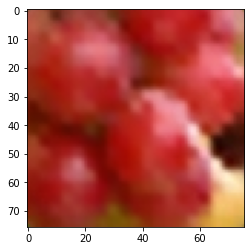

Epoch = 1, loss = 0.1287


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


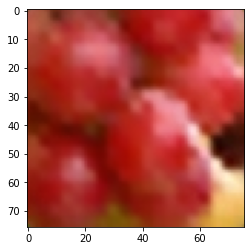

Epoch = 2, loss = 0.1287


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


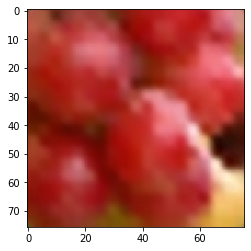

Epoch = 3, loss = 0.1287


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


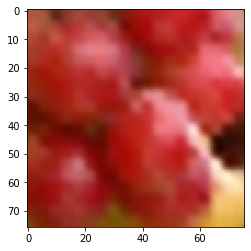

Epoch = 4, loss = 0.1287


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


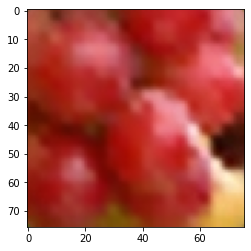

In [9]:
learning_rate = 1e-6
model = EDSR(upsample_factor=4, num_res_blocks=32)

PATH = '/content/gdrive/My Drive/EDSR_weighs_YCrCb.pt'
model.load_state_dict(torch.load(PATH))
model.eval()

optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

train(model, optimizer, imgs_x4_test, imgs_hd_test)

In [9]:
def test(model, imgs_x4_test, imgs_hd_test, imgs_bicubic_test):
    model = model.to(device=device)
    x = imgs_x4_test.to(device=device, dtype=dtype_)
    resol = model(x).detach()
    y_ssim = ycbcr2rgb(np.array(np.transpose(imgs_hd_test[0], [1, 2, 0])))
    test_ssim = ycbcr2rgb(np.array(np.transpose(resol[0].cpu(), [1, 2, 0])))
    bicubic_ssim = ycbcr2rgb(np.array(np.transpose(imgs_bicubic_test[0], [1, 2, 0])))
    print('SSIM_test = ', ssim(y_ssim, test_ssim, multichannel=True))
    print('PSNR_test = ', psnr(y_ssim[:,:,0], test_ssim[:,:,0], data_range=2))
    print('SSIM_bicubic = ', ssim(y_ssim, bicubic_ssim, multichannel=True))
    print('PSNR_bicubic = ', psnr(y_ssim[:,:,0], bicubic_ssim[:,:,0], data_range=2))
    for i in range(resol.size(0)):
        res = ycbcr2rgb(np.array(np.transpose(resol[i].cpu(), [1,2,0])))
        save_image(torch.tensor(np.transpose(res, [2,0,1])), '/content/gdrive/My Drive/test_EDSR_YCrCb/{}.png'.format(i+5))
    for i in range(imgs_hd_test.size(0)):
        res = ycbcr2rgb(np.array(np.transpose(imgs_hd_test[i].cpu(), [1,2,0])))
        save_image(torch.tensor(np.transpose(res, [2,0,1])), '/content/gdrive/My Drive/test_EDSR_YCrCb/{}_hd.png'.format(i+5))
    for i in range(imgs_bicubic_test.size(0)):
        res = ycbcr2rgb(np.array(np.transpose(imgs_bicubic_test[i].cpu(), [1,2,0])))
        save_image(torch.tensor(np.transpose(res, [2,0,1])), '/content/gdrive/My Drive/test_EDSR_YCrCb/{}_bicubic.png'.format(i+5))

In [18]:
imgs_hd_test_set5 = []
imgs_x4_test_set5 = []
imgs_bicubic_test_set5 = []
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
folder_path = "/content/gdrive/My Drive/Test/Set5"
filename = 'baby_GT.bmp'
img_hd = plt.imread(os.path.join(folder_path, filename))
img_x4 = degradation(img_hd, 4)
img_bicubic = create_bicubic(img_hd, 4)
img_hd = rgb2ycbcr(img_hd / 255.0)
img_x4 = rgb2ycbcr(img_x4 / 255.0)
img_bicubic = rgb2ycbcr(img_bicubic / 255.0)
img_hd = np.transpose(img_hd, [2, 0, 1])
img_x4 = np.transpose(img_x4, [2, 0, 1])
img_bicubic = np.transpose(img_bicubic, [2, 0, 1])
imgs_hd_test_set5.append(img_hd)
imgs_x4_test_set5.append(img_x4)
imgs_bicubic_test_set5.append(img_bicubic)
imgs_hd_test_set5 = np.stack(imgs_hd_test_set5)
imgs_x4_test_set5 = np.stack(imgs_x4_test_set5)
imgs_bicubic_test_set5 = np.stack(imgs_bicubic_test_set5)

Mounted at /content/gdrive


In [19]:
# model = EDSR(upsample_factor=4, num_res_blocks=32)

# PATH = '/content/gdrive/My Drive/EDSR_weighs_YCrCb.pt'
# model.load_state_dict(torch.load(PATH))
# model.eval()
test(model, torch.tensor(imgs_x4_test_set5), torch.tensor(imgs_hd_test_set5), torch.tensor(imgs_bicubic_test_set5))

SSIM_test =  0.9077824411505314
PSNR_test =  35.419586153569476
SSIM_bicubic =  0.909092098983038
PSNR_bicubic =  35.51301021752087


In [21]:
ssim_t = np.array([0.9077824411505314, 0.9069378205278588, 0.7987518991645275, 0.8228215773361632, 0.8795720763987062])
psnr_t = np.array([35.419586153569476, 33.23573420474343, 26.212693967369333, 32.691260722564834, 30.34223331792587])

In [24]:
print('SSIM =', np.mean(ssim_t))
print('PSNR =', np.mean(psnr_t))

SSIM = 0.8631731629155575
PSNR = 31.58030167323459
